# Importing sentiment analysis model from Hugging Face

In [130]:
from transformers import pipeline
sentiment_pipeline = pipeline("sentiment-analysis")

No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english and revision af0f99b (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english).
Using a pipeline without specifying a model name and revision in production is not recommended.
Some layers from the model checkpoint at distilbert-base-uncased-finetuned-sst-2-english were not used when initializing TFDistilBertForSequenceClassification: ['dropout_19']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFDistilBertForSequenceCla

# Importing necessary libraries

In [89]:
import pandas as pd
import pyarrow as pa
import pyarrow.parquet as pq
import matplotlib.pyplot as plt
import seaborn as sns

# Reading the parquet files

In [6]:
data_df = pd.read_parquet("../datasets/data.parquet")

In [7]:
data_df.head()

,id,category,title,store,rating,no_rating
0,0,Beauty & Personal Care,"Gillette Mach3 Men's Razor Blade Refills, 8 Count",Gillette Store,4.7,"11,216 ratings"
1,1,Beauty & Personal Care,"Gillette Series 3X Protection Shave Foam, Sens...",Gillette Store,4.5,231 ratings
2,2,Beauty & Personal Care,"Secret Original Anti-Perspirant/Deodorant, Inv...",Secret Store,4.7,"1,343 ratings"
3,3,Health & Household,Natracare Non-Applicator 100% Organic Cotton T...,NATRACARE Store,4.6,915 ratings
4,4,Health & Household,Pepcid Complete Acid Reducer + Antacid Chewabl...,Pepcid Store,4.8,"5,566 ratings"


In [10]:
review_df = pd.read_parquet("../datasets/review.parquet")

In [11]:
review_df.head()

,id,name,data,reviewers_rating,review
0,0,oldcarfrank,"Reviewed in the United States on October 7, 2022",5.0,second rate
1,0,Jerry,"Reviewed in the United States on October 5, 2022",5.0,I've got a couple of razors which I can use to...
2,0,Brandy Phillips,"Reviewed in the United States on October 5, 2022",5.0,These razors are great for sensitive skin and ...
3,0,Zercot,"Reviewed in the United States on October 4, 2022",5.0,"Like most razor blades, the cost is high. But ..."
4,0,Alexander,"Reviewed in the United States on October 4, 2022",5.0,I didn't liked it. Fake


# Cleaning the data

### Removing Emoji

In [65]:
import re

def remove_emoji(string):
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002500-\U00002BEF"  # chinese char
                               u"\U00002702-\U000027B0"
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               u"\U0001f926-\U0001f937"
                               u"\U00010000-\U0010ffff"
                               u"\u2640-\u2642"
                               u"\u2600-\u2B55"
                               u"\u200d"
                               u"\u23cf"
                               u"\u23e9"
                               u"\u231a"
                               u"\ufe0f"  # dingbats
                               u"\u3030"
                               "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', str(string))

In [66]:
new_df["review"] = new_df["review"].apply(lambda x: remove_emoji(x))

/tmp/ipykernel_214544/3541759965.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["review"] = new_df["review"].apply(lambda x: remove_emoji(x))


### Removing HTML tags

In [70]:
def remove_tags(string):
    return re.sub(r"<\w*>","",string)

In [71]:
new_df["review"] = new_df["review"].apply(lambda x: remove_tags(x))

/tmp/ipykernel_214544/1520409001.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["review"] = new_df["review"].apply(lambda x: remove_tags(x))


In [73]:
new_df.iloc[42]["review"]

'Re: Headline..I recently did my own razor rating test  using the Mach 3, Harry’s and DSC, four blade razor. Mach 3 far  the best. 1. More shaves per cartridge by far +15. -Harry’s razor about 6 to 8 , varied per cartridge . DSC - 5-6. Note: I am an ex-barber, retired and have an average beard.Mach 3 had the least skin irritation and seldom nicked  the skin and was easy to use under the nose and  around the chin. Harry’s a bit bulky under the nose/ upper lip, but it has a trimmer edge on reverse to make up for it, and  it is feels great on the face.  DSC- left most nicks and irritation.Mach 3 handle ok, But Harry’s felt weighty and comfortable to use, the best of all the handles. DSC razor  handle felt cheap.So the Gillette, though pricey , was the Best Buy IMO. But Harry’s a close rival- a refill pack $2-$3less  expensive per pack ( depending  where bought vis a vis Gillette) ,though a bit more more  per shave. Only a matter of cents so  I still have Harry’s razor handle , and may giv

# Trying out sentiment analysis

In [80]:
sentiment = []
for i in new_df["review"]:
    sentiment.append(sentiment_pipeline(i)[0]["label"])

In [81]:
new_df["sentiment"] = sentiment

/tmp/ipykernel_214544/2911768758.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df["sentiment"] = sentiment


In [82]:
new_df.head()

,id,name,data,reviewers_rating,review,sentiment
0,0,oldcarfrank,"Reviewed in the United States on October 7, 2022",5.0,second rate,NEGATIVE
1,0,Jerry,"Reviewed in the United States on October 5, 2022",5.0,I've got a couple of razors which I can use to...,POSITIVE
2,0,Brandy Phillips,"Reviewed in the United States on October 5, 2022",5.0,These razors are great for sensitive skin and ...,POSITIVE
3,0,Zercot,"Reviewed in the United States on October 4, 2022",5.0,"Like most razor blades, the cost is high. But ...",POSITIVE
4,0,Alexander,"Reviewed in the United States on October 4, 2022",5.0,I didn't liked it. Fake,NEGATIVE


# Reducing the data

### Ploting the categories in bar chart

In [85]:
categories = list(data_df["category"].unique())

In [86]:
len(categories)

16

In [87]:
cat_count = []
for i in categories:
    cat_count.append(len(data_df[data_df["category"]==i]))
cat_count

[39, 80, 7, 3, 4, 6, 31, 1, 2, 3, 1, 12, 2, 16, 7, 6]

In [90]:
colors = sns.color_palette('pastel')[0:16]

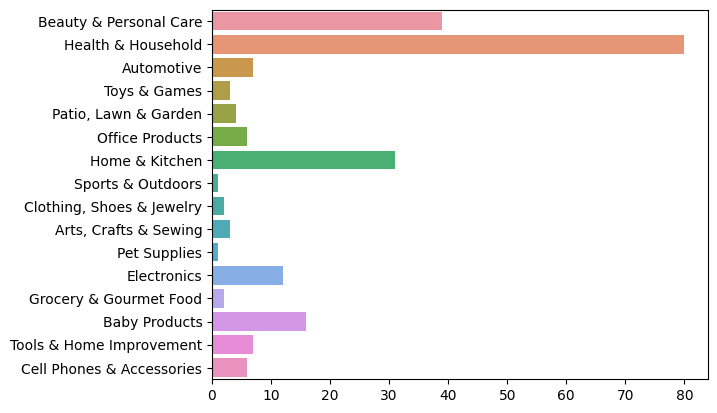

In [98]:
bar_plot = sns.barplot(x=cat_count,y=categories)
plt.show()

In [ ]:
selection = ["Electronics","Cell Phones & Accessories","Beauty & Personal Care"]

In [107]:
data_df = data_df[(data_df["category"]=="Electronics") | (data_df["category"]=="Cell Phones & Accessories") | (data_df["category"]=="Beauty & Personal Care")]

In [109]:
len(data_df)

57

In [117]:
data_df["no_rating"] = data_df["no_rating"].str.replace("ratings","")
data_df["no_rating"] = data_df["no_rating"].str.replace(",","")
data_df["no_rating"] = data_df["no_rating"].str.replace("rating","")
data_df.head()

/tmp/ipykernel_214544/118795873.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["no_rating"] = data_df["no_rating"].str.replace("ratings","")
/tmp/ipykernel_214544/118795873.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["no_rating"] = data_df["no_rating"].str.replace(",","")
/tmp/ipykernel_214544/118795873.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the 

,id,category,title,store,rating,no_rating
0,0,Beauty & Personal Care,"Gillette Mach3 Men's Razor Blade Refills, 8 Count",Gillette Store,4.7,11216
1,1,Beauty & Personal Care,"Gillette Series 3X Protection Shave Foam, Sens...",Gillette Store,4.5,231
2,2,Beauty & Personal Care,"Secret Original Anti-Perspirant/Deodorant, Inv...",Secret Store,4.7,1343
12,13,Beauty & Personal Care,"Jan Marini Skin Research C-Esta Serum, 1.0 Fl Oz",None,4.7,351
18,20,Beauty & Personal Care,Ban Original Unscented 24-hour Invisible Antip...,Ban Store,4.8,429


In [118]:
data_df["no_rating"] = pd.to_numeric(data_df["no_rating"])

/tmp/ipykernel_214544/2486611264.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_df["no_rating"] = pd.to_numeric(data_df["no_rating"])


In [120]:
data_df.head()

,id,category,title,store,rating,no_rating
0,0,Beauty & Personal Care,"Gillette Mach3 Men's Razor Blade Refills, 8 Count",Gillette Store,4.7,11216
1,1,Beauty & Personal Care,"Gillette Series 3X Protection Shave Foam, Sens...",Gillette Store,4.5,231
2,2,Beauty & Personal Care,"Secret Original Anti-Perspirant/Deodorant, Inv...",Secret Store,4.7,1343
12,13,Beauty & Personal Care,"Jan Marini Skin Research C-Esta Serum, 1.0 Fl Oz",None,4.7,351
18,20,Beauty & Personal Care,Ban Original Unscented 24-hour Invisible Antip...,Ban Store,4.8,429


In [119]:
data_df.describe()

,id,rating,no_rating
count,57.000000,57.00000,57.000000
mean,351.894737,4.55614,4252.912281
std,266.441342,0.25982,8830.116292
min,0.000000,3.50000,1.000000
25%,50.000000,4.40000,122.000000
50%,529.000000,4.60000,591.000000
75%,589.000000,4.70000,4112.000000
max,633.000000,5.00000,51710.000000


In [124]:
data_df[(data_df["no_rating"]<4112) & (data_df["no_rating"]>591)]

,id,category,title,store,rating,no_rating
2,2,Beauty & Personal Care,"Secret Original Anti-Perspirant/Deodorant, Inv...",Secret Store,4.7,1343
21,23,Beauty & Personal Care,"Clinique All About Eyes Cream for Unisex, 0.5 ...",None,4.6,1676
23,25,Beauty & Personal Care,PCA SKIN Moisturizing Collagen Night Cream - A...,None,4.7,1481
24,26,Beauty & Personal Care,Old Spice High Endurance Fresh Scent Body Wash...,Old Spice Store,4.7,780
131,536,Cell Phones & Accessories,Tracfone Carrier-Locked Motorola Moto e5 4G LT...,Motorola Store,4.3,670
132,537,Beauty & Personal Care,Olay Fresh Outlast Cooling White Strawberry & ...,Olay Store,4.1,1036
136,542,Electronics,Samsung Galaxy Watch GPS & Bluetooth w/ 42mm B...,SAMSUNG Store,4.5,768
137,543,Beauty & Personal Care,Love Beauty And Planet Radical Refresher Body ...,Love Beauty And Planet Store,4.7,3197
166,577,Beauty & Personal Care,"Old Spice Body Wash for Men, Exfoliate with Ch...",Old Spice Store,4.8,964
186,600,Beauty & Personal Care,"Pantene Body Boosting Mousse, Pro-V Maximum Fu...",Pantene Store,4.7,1208


In [125]:
beauty_df = data_df[data_df["category"]=="Beauty & Personal Care"]
beauty_df.head()

,id,category,title,store,rating,no_rating
0,0,Beauty & Personal Care,"Gillette Mach3 Men's Razor Blade Refills, 8 Count",Gillette Store,4.7,11216
1,1,Beauty & Personal Care,"Gillette Series 3X Protection Shave Foam, Sens...",Gillette Store,4.5,231
2,2,Beauty & Personal Care,"Secret Original Anti-Perspirant/Deodorant, Inv...",Secret Store,4.7,1343
12,13,Beauty & Personal Care,"Jan Marini Skin Research C-Esta Serum, 1.0 Fl Oz",None,4.7,351
18,20,Beauty & Personal Care,Ban Original Unscented 24-hour Invisible Antip...,Ban Store,4.8,429


In [134]:
len(beauty_df)

39

In [127]:
id_list = list(beauty_df["id"].unique())

In [ ]:
for pid in id_list:
    df = review_df[review_df["id"]==pid]
    sentiment = []
    for i in df["review"]:
        try:
            sentiment.append(sentiment_pipeline(i)[0]["label"])
        except:
            sentiment.append("Negative")
    if len(sentiment)!=0:
        print("id: ",pid,"\npositive %",(sentiment.count("POSITIVE")/len(sentiment))*100,"\n\n")

id:  0 
positive % 72.8 


id:  1 
positive % 53.125 


id:  2 
positive % 75.23809523809524 


id:  13 
positive % 80.0 


id:  20 
positive % 83.52941176470588 


id:  22 
positive % 83.33333333333334 


id:  23 
positive % 67.58620689655173 


id:  25 
positive % 80.90277777777779 


id:  26 
positive % 80.0 


id:  35 
positive % 100.0 


id:  42 
positive % 62.878787878787875 


id:  45 
positive % 71.54471544715447 


id:  46 
positive % 55.82329317269076 


id:  48 
positive % 62.311557788944725 


id:  50 
positive % 81.72413793103448 


id:  54 
positive % 93.75 


id:  56 
positive % 57.14285714285714 


id:  70 
positive % 66.73346693386773 


id:  71 
positive % 61.77062374245473 


id:  73 
positive % 50.50100200400801 


id:  81 
positive % 60.4 


id:  90 
positive % 74.0 


id:  98 
positive % 72.14428857715431 


id:  504 
positive % 75.0 


id:  537 
positive % 56.666666666666664 


id:  543 
positive % 69.0376569037657 


id:  577 
positive % 83.72093023255815 


id:

In [149]:
data_df[data_df["id"]==542]

,id,category,title,store,rating,no_rating
136,542,Electronics,Samsung Galaxy Watch GPS & Bluetooth w/ 42mm B...,SAMSUNG Store,4.5,768


In [159]:
pdt_df = pd.DataFrame()

In [165]:
lst = [542,612,536,620,622,54,577]